# Time Series Forecasting with Prophet 

## Mini-Vignette: Modeling the Price of Ethereum

By: [Paul Jeffries](https://twitter.com/ByPaulJ) 

Created: 03/27/2019

## What is Prophet?

[Prophet](https://facebook.github.io/prophet/) is an open source package (for both Python and R) for forecasting time series data based on an additive model where non-linear trends are fit wth yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (according to the pcakage documentation). Prophet is open source software released by Facebook's core Data Science team. It is [available for download](https://facebook.github.io/prophet/docs/installation.html) on CRAN and PyPI. The academic paper (still in peer-review at the time of this writing) [is available here](https://peerj.com/preprints/3190/). 

tl;dr --> Prophet is essentially Facebook's data science team's version of [auto-ARIMA](https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/).

## Use Case: Understanding Seasonal & Temporal Patterns in the Price of Ethereum

Prophet is particularly well-suited for a use case like examining the [daily price of ETH](https://coinmarketcap.com/currencies/ethereum/) (aka Ether)--the 2nd largest cryptoasset [after Bitcoin](https://www.youtube.com/watch?v=0UBk1e5qnr4)--as we have multiple years of daily data, and we suppose that there may be seasonal effects at various levels of granularity that moderate price movement in some way. The motivation for this vignette came from some of [my other work examining price movements in the crypto markets](https://github.com/pmaji/crypto-whale-watching-app), in which I observed many traders claiming that there was a discernable "weekend bump" or "weekend bull" effect in crypto markets. To summarize, **there have been many claims that weekends are, *ceteris paribus*, more bullish for ETH trading than weekdays. This methodology will enable us to test the veracity of such claims.** While in this vignette I will build a "forecast" for the price of ETH, the main goal of this vignette is not to arrive at a perfect price forecast. Instead, the goal is to make use of the explanatory capabilities built into the Prophet package to look for evidence that may either support or contradict the 'weekend bull' thesis. 

This vignette doesn't fully exlore anywhere near all of the features of Prophet, and is only meant as an introduction. Hopefully you are inspired by what you see below to think of ways to improve this work, perhaps applying it to other time series forecasting applications as well. I am by no means an expert (either of Prophet specifically, or time-series forecasting writ large), but if you have any questions, feel free to [open an issue here on GitHub](https://github.com/pmaji/data-science-toolkit/issues), and, as always, I'll do my best to respond expeditiously. With that, let's get into the code!

## Basic Setup

In [18]:
# key packages used throughout:

# basic packages
import pandas as pd
import datetime
import numpy as np

# forecasting package
from fbprophet import Prophet
# package to import historical crypto OHLC data
from cryptory import Cryptory

## Pulling Historical Price Data for Ethereum

There are plenty ways that one can access historical OHLC data for top cryptocurrencies. If you're interested in data science projects pertaining to cryptocurrencies and/or how to access pertinent crypto data specifically, I highly recommend checking out two other public projects I maintain that deal in the crypto space:

- [This one here](https://github.com/pmaji/financial-asset-comparison-tool/blob/master/README.md) is a Python app that tracks "whale" (aka large volume) activity in US crypto markets
    - This project pulls OHLC crypto data from [Coin Metrics](https://coinmetrics.io/)
- [This one here](https://github.com/pmaji/crypto-whale-watching-app) is an R Shiny app that allows for the comparison of the performance of traditional financial assets vs. cryptos
    - This project pulls OHLC crypto data [from GDAX's (aka Coinbase Pro's) API](https://docs.pro.coinbase.com/?r=1)
    
That said, for this vignette, I decided to use the very simple and user-friendly [package "cryptory"](https://github.com/dashee87/cryptory) to pull in OHLC data for ETH (sourced from CoinMarketCap). Why ETH... why not Bitcoin or insert-other-cryptocurrency-here? I chose ETH simply because it's the project and community in which I am most personally interested and involved. If you want to see what a forecast for another cryptoasset would look like, simply fork this repo, change one line of code in this notebook, and if you discover something cool, let me know (my twitter is hyperlinked above in the byline)!

In [19]:
# initialize the cryptory object 
# pull data from start of 2015 to present day
my_cryptory_obj = Cryptory(from_date = "2015-01-01")

# get historical ETH OHLC data from coinmarketcap
eth_ohlc_hist_df = my_cryptory_obj.extract_coinmarketcap("ethereum")

# inspect the results
print(eth_ohlc_hist_df.shape)
eth_ohlc_hist_df.head()

(1331, 7)


,date,open,high,low,close,volume,marketcap
0,2019-03-29,139.34,142.55,138.05,142.50,5125602702,15025361637
1,2019-03-28,141.01,141.01,138.43,139.42,4163212475,14698609599
2,2019-03-27,135.45,141.08,135.34,140.99,5228240093,14862394451
3,2019-03-26,135.05,135.46,133.76,135.46,4499271679,14277816266
4,2019-03-25,137.08,137.70,133.49,135.03,4480516753,14230733149


From the above we can see that we have some pretty clean data to work with. In most real-world use cases, we won't be that lucky, so if we did have unclean data, here is where in the workflow I would turn to handy packages [like pyjanitor](https://github.com/ericmjl/pyjanitor). If you're interested in one that would look like, you can see that at work in a recent [vignette I wrote up on radar charts here](https://github.com/pmaji/data-science-toolkit/blob/master/eda-and-visualization/radar_charts.ipynb). 

For the purpose of this project, all we really need from the colums above is our date column, and our price column. For price, we could technically choose from any of the OHLC columns, but I'm going to go with closing price. There is a fundamentals vs. technicals argument to be made here about whether I should care more about closing price than market cap, but that's not the purpose of this vignette. If that subject interests you, [here's a good place to start](https://www.thebalance.com/why-per-share-price-is-not-important-3140791) to learn more. 

In [20]:
# subset to just the date and the closing price
eth_price_hist_df = my_cryptory.extract_coinmarketcap("ethereum").loc[:,['date','close']]

eth_price_hist_df = eth_price_hist_df.loc[eth_price_hist_df['date']>='01APR018',:]
# rename dt column to ds and continous value column to y per fbprophet's docs
eth_price_hist_df.columns = ['ds', 'y']

In [21]:
eth_price_hist_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [22]:
saturating_min = 0
saturating_max = 300

# eth_price_hist_df.loc[:,'floor'] = saturating_min
# eth_price_hist_df.loc[:,'cap'] = saturating_max

In [23]:
m = Prophet(
)
m.fit(eth_price_hist_df)

/Users/pauljeffries/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pauljeffries/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
# Python
future = m.make_future_dataframe(periods=30)
# future.loc[:,'floor'] = saturating_min
# future.loc[:,'cap'] = saturating_max
future.tail()

,ds
388,2019-04-24
389,2019-04-25
390,2019-04-26
391,2019-04-27
392,2019-04-28


In [25]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
388,2019-04-24,131.946488,83.106043,187.276866
389,2019-04-25,135.794357,83.146822,188.745617
390,2019-04-26,135.650640,81.498643,189.010529
391,2019-04-27,139.445305,84.021635,193.919165
392,2019-04-28,140.106095,86.745125,194.500710


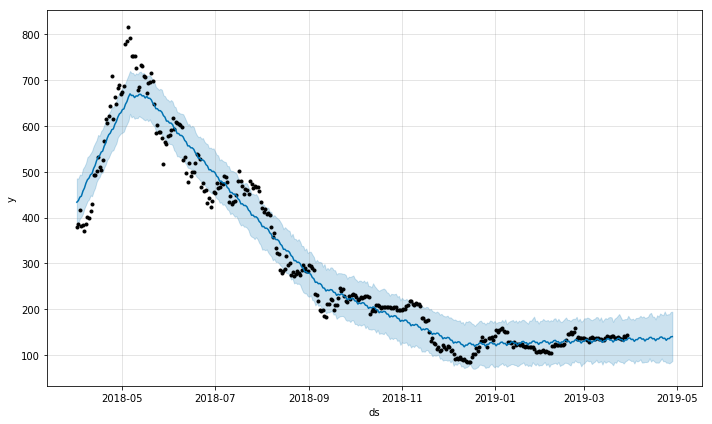

In [26]:
# Python
fig1 = m.plot(forecast)

In [27]:
%run -i 'prophet_helper_functions.py'

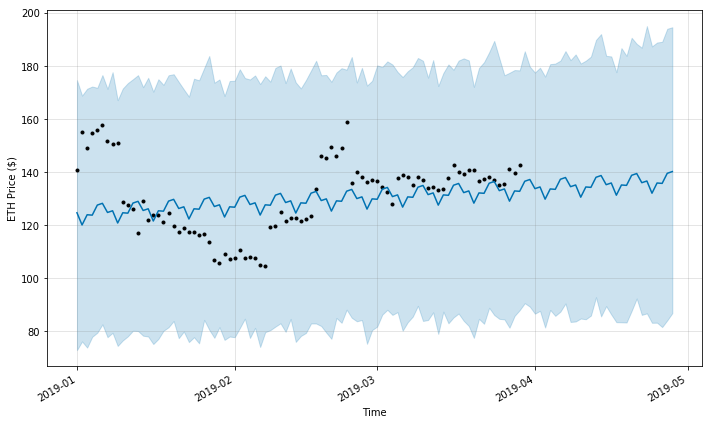

In [28]:
dt_restricted_prophet_plt(
    m = m,
    fcst = forecast,
    visible_window_start_dt = '01JAN2019',
    visible_window_end_dt = '01JUNE2019',
    ylabel = "ETH Price ($)",
    xlabel = "Time",
    x_axis_date_format = '%Y-%m'
);

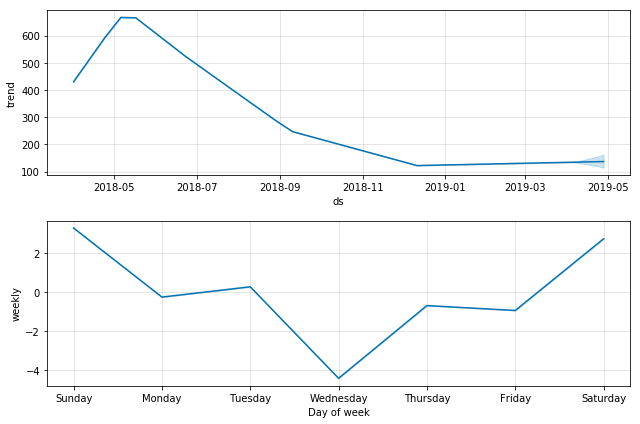

In [29]:
# Python
fig2 = m.plot_components(forecast)

In [30]:
%%capture
# capturing warnings here because one of the dependencies throws a bunch of numpy deprecation warnings

from fbprophet.diagnostics import cross_validation
df_dv = cross_validation(m, horizon = '30 days')

INFO:fbprophet:Making 17 forecasts with cutoffs between 2018-07-02 00:00:00 and 2019-02-27 00:00:00


In [31]:
df_dv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-07-03,418.768755,369.883368,463.001689,464.20,2018-07-02
1,2018-07-04,399.406512,351.641068,446.101334,467.32,2018-07-02
2,2018-07-05,411.014026,363.136442,455.965259,474.41,2018-07-02
3,2018-07-06,397.531018,349.457604,443.742085,474.01,2018-07-02
4,2018-07-07,401.746848,356.382634,441.835370,491.66,2018-07-02


In [32]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_dv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
2,3 days,1216.630078,34.880225,30.622070,0.155008,0.843137
303,4 days,1202.954675,34.683637,30.456102,0.159744,0.862745
213,4 days,1209.760750,34.781615,30.586664,0.158935,0.862745
393,4 days,1202.118730,34.671584,30.467017,0.161849,0.862745
423,4 days,1203.826241,34.696199,30.582786,0.162910,0.862745


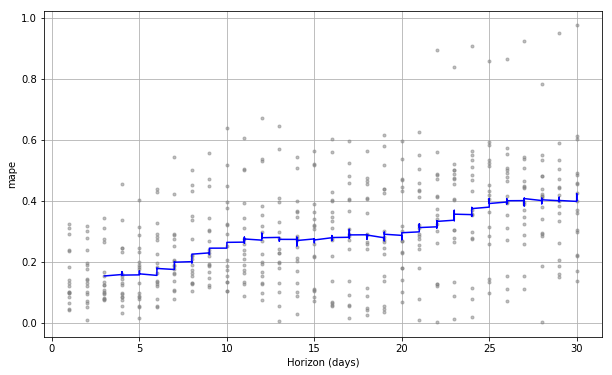

In [33]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_dv, metric = 'mape')